<a href="https://colab.research.google.com/github/sagravat/google-cloudml-workshops/blob/master/tflite/Quantized_aware_training_and_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantized Aware Training with Inference example
Demonstrates using the tensorflow model optimization API to perform quantized aware training and use the TF Lite python interpreter to perform inference with a uint8 converted image

### Install module from github since pypy is not in sync with latest release as of 7/18/2019

In [0]:
!pip install --user -e git://github.com/tensorflow/model-optimization.git@v0.1.2#egg=tensorflow_model_optimization_v0.1.2

Obtaining tensorflow_model_optimization_v0.1.2 from git+git://github.com/tensorflow/model-optimization.git@v0.1.2#egg=tensorflow_model_optimization_v0.1.2
  Cloning git://github.com/tensorflow/model-optimization.git (to revision v0.1.2) to ./src/tensorflow-model-optimization-v0.1.2
  Running command git clone -q git://github.com/tensorflow/model-optimization.git /content/src/tensorflow-model-optimization-v0.1.2
  Running command git checkout -q c2c0fc1f188685513d32a58b4106ebe40037a307
  Running setup.py develop for tf-model-optimization-nightly


### Make sure to restart the runtime and then you'll see the module in the path below

In [0]:
import sys
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/root/.local/lib/python3.6/site-packages',
 '/content/src/tensorflow-model-optimization-v0.1.2',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

### Verify the module has been installed

In [0]:
from tensorflow_model_optimization.python.core.quantization.keras.quantize_emulate import QuantizeEmulate


## Perform the training

In [0]:
from __future__ import print_function

import tensorflow as tf  # pylint: disable=g-bad-import-order

from tensorflow_model_optimization.python.core.quantization.keras.quantize_emulate import QuantizeEmulate
from tensorflow_model_optimization.python.core.quantization.keras.quantize_emulate_wrapper import QuantizeEmulateWrapper

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

if tf.keras.backend.image_data_format() == 'channels_first':
  x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
  x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
  input_shape = (1, img_rows, img_cols)
else:
  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
  input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

l = tf.keras.layers
quant_params = {'num_bits': 8}

model = tf.keras.Sequential([
    QuantizeEmulate(
        l.Conv2D(32, 5, padding='same', activation='relu'),
        input_shape=input_shape,
        **quant_params),
    l.MaxPooling2D((2, 2), (2, 2), padding='same'),
    QuantizeEmulate(
        l.Conv2D(64, 5, padding='same', activation='relu'), **quant_params),
    l.MaxPooling2D((2, 2), (2, 2), padding='same'),
    l.Flatten(),
    QuantizeEmulate(l.Dense(1024, activation='relu'), **quant_params),
    l.Dropout(0.4),
    QuantizeEmulate(l.Dense(num_classes), **quant_params),
    # TODO(alanchiao): fuse softmax once we've handled it.
    l.Softmax(),
])

# Dump graph to /tmp for verification on tensorboard.
graph_def = tf.get_default_graph().as_graph_def()
with open('/tmp/mnist_model.pbtxt', 'w') as f:
  f.write(str(graph_def))

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adadelta(),
    metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Export to Keras.
keras_file = '/tmp/quantized_mnist.h5'
tf.keras.models.save_model(model, keras_file)

# Convert to TFLite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(
    keras_file,
    custom_objects={'QuantizeEmulateWrapper': QuantizeEmulateWrapper})
converter.inference_type = tf.lite.constants.QUANTIZED_UINT8
input_arrays = converter.get_input_arrays()
converter.quantized_input_stats = {input_arrays[0]: (0., 255.)}  # mean, std_dev
tflite_model = converter.convert()
open('/tmp/quantized_mnist.tflite', 'wb').write(tflite_model)

11493376/11490434 [==============================] - 0s 0us/step


W0718 23:14:55.822640 140712049248128 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 9s 155us/sample - loss: 2.2859 - acc: 0.1362 - val_loss: 2.2624 - val_acc: 0.1693
Epoch 2/12
60000/60000 [==============================] - 6s 92us/sample - loss: 2.2400 - acc: 0.2367 - val_loss: 2.2111 - val_acc: 0.3572
Epoch 3/12
60000/60000 [==============================] - 6s 92us/sample - loss: 2.1836 - acc: 0.3661 - val_loss: 2.1442 - val_acc: 0.5497
Epoch 4/12
60000/60000 [==============================] - 6s 92us/sample - loss: 2.1055 - acc: 0.4894 - val_loss: 2.0481 - val_acc: 0.6643
Epoch 5/12
60000/60000 [==============================] - 5s 91us/sample - loss: 1.9944 - acc: 0.5869 - val_loss: 1.9110 - val_acc: 0.7147
Epoch 6/12
60000/60000 [==============================] - 6s 93us/sample - loss: 1.8430 - acc: 0.6499 - val_loss: 1.7280 - val_acc: 0.7547
Epoch 7/12
60000/60000 [==================

W0718 23:16:13.007611 140712049248128 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0718 23:16:13.008793 140712049248128 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Test loss: 0.6748503169059753
Test accuracy: 0.8516


W0718 23:16:13.917068 140712049248128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/lite/python/util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0718 23:16:13.918221 140712049248128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


3281280

In [0]:
!ls /tmp/quantized_mnist.tflite

/tmp/quantized_mnist.tflite


## Load the TF lite model

In [0]:
 interpreter = tf.lite.Interpreter("/tmp/quantized_mnist.tflite")

### allocate the tensors and get the input/output details

In [0]:
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

### Convert a test image to uint8

In [0]:
import numpy as np

data = x_test[45].reshape(1, img_rows, img_cols, 1)
data = 255 * data # scale by 255
img = data.astype(np.uint8)
img.shape


(1, 28, 28, 1)

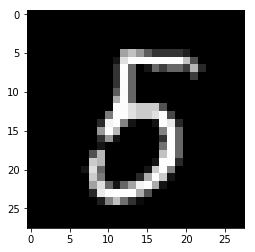

In [0]:
from matplotlib import pyplot as plt

pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

### Run the interpreter

In [0]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.uint8)
interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data, "\npredicted value: ", np.argmax(output_data))


[[ 9  4  8 57  5 90 16  4 55  8]] 
predicted value:  5
